In [1]:
####################################################
#Import Libraries
####################################################

import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 80
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
####################################################
#hyperparameters
####################################################

batch_size = 64
input_size = 7
hidden_size_1 = 64
hidden_size_2 = 64
hidden_size_3 = 64
hidden_size_4 = 64
hidden_size_5 = 64
hidden_size_6 = 64
output_size = 6
dropout_1 = 0.5
dropout_2 = 0.5
dropout_3 = 0.5
dropout_4 = 0.5
dropout_5 = 0.5
dropout_6 = 0.5

seq_len = 30
learning_rate = 0.003
num_epochs = 200


seed = 1504062
#seed = np.random.randint(10000000, size=1).item() #random seed

In [3]:
####################################################
#data importing
####################################################

df = pd.read_excel('ALL VAR cleaned.xlsx')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')
df.head()

,Avg. Hum (%),Avg. Temp. (Celcius),Max. Temp. (Celcius),Min. Temp. (Celcius),Total Rainfall (mm),Wind Speed (Knots),Total Sunshine Hrs.,SO2 (ppb),NO2 (ppb),CO (ppm),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3)
Date,,,,,,,,,,,,,
2013-01-01,69,17.0,24.6,11.0,0,0.0,5.1,11.167710,31.700016,3.013273,6.001289,234.622679,407.192110
2013-01-02,68,18.4,26.7,11.5,0,2.0,5.5,10.918571,37.720404,2.879839,5.035271,253.715176,423.981442
2013-01-03,74,18.9,25.2,14.9,0,0.0,0.0,10.960147,49.219523,3.048507,5.853110,270.920463,412.034426
2013-01-04,70,19.9,25.6,14.8,0,2.0,0.0,14.988741,26.149916,2.203914,10.753946,241.622788,267.661431
2013-01-05,60,18.7,25.0,14.6,0,2.0,2.5,7.386188,34.626808,1.423127,5.642880,137.012858,193.417860


In [4]:
#data scaling
df_scaled = (df - df.mean())/ df.std()
df_scaled.head()

#storing mean and std
df_np_mean = df.mean().to_numpy()
df_np_std = df.std().to_numpy()

#dropping date column
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)
df_scaled.head()

,Avg. Hum (%),Avg. Temp. (Celcius),Max. Temp. (Celcius),Min. Temp. (Celcius),Total Rainfall (mm),Wind Speed (Knots),Total Sunshine Hrs.,SO2 (ppb),NO2 (ppb),CO (ppm),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3)
0,-0.276565,-2.252157,-1.771845,-2.348275,-0.362854,-1.909625,-0.041315,0.387179,0.676108,0.909184,0.056248,2.566658,3.152157
1,-0.367972,-1.912556,-1.203057,-2.245625,-0.362854,-0.197161,0.094066,0.357725,1.005929,0.816029,-0.067994,2.872272,3.335737
2,0.180470,-1.791270,-1.609334,-1.547603,-0.362854,-1.909625,-1.767425,0.362640,1.635896,0.933782,0.037191,3.147677,3.205105
3,-0.185158,-1.548697,-1.500994,-1.568133,-0.362854,-0.197161,-1.767425,0.838921,0.372052,0.344141,0.667500,2.678709,1.626486
4,-1.099229,-1.839784,-1.663505,-1.609193,-0.362854,-0.197161,-0.921292,-0.059892,0.836450,-0.200956,0.010152,1.004217,0.814684


In [5]:
####################################################
#data sequencing
####################################################

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+1 >= len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:7], sequences[end_ix+1, 7:13]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

array = df_scaled.iloc[:, :].values
print ('shape of the datset array: {}'.format(array.shape))
X, y = split_sequences(array, seq_len)
X_array = np.array(X, dtype = np.float32)
y_array = np.array(y)
print ('sequenced X array shape: {}'.format(X_array.shape))
print ('sequenced y array shape: {}'.format(y_array.shape))

shape of the datset array: (2184, 13)
sequenced X array shape: (2153, 30, 7)
sequenced y array shape: (2153, 6)


In [6]:
#output mask preparation

df_mask = pd.read_excel('COMBINED CAMS MASK.xlsx')
#print(df_mask.head())

mask_array = df_mask.iloc[:, :].values
#print(mask_array.shape)

#sequencing
def mask_sequence(sequence, n_steps):
    y = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_iy = i + n_steps
        # check if we are beyond the dataset
        if end_iy+1 >= len(sequence): break
        # gather input and output parts of the pattern
        seq_y = sequence[end_iy+1, 0:6]
        y.append(seq_y)
    return y

mask_list = mask_sequence(mask_array, seq_len)
mask_array = np.array(mask_list)
print(mask_array.shape)

(2153, 6)


In [7]:
####################################################
#making dataset and subsets
####################################################

class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = X_array.shape[0]
        self.X_data = torch.from_numpy(X_array)
        self.y_data = torch.from_numpy(y_array)
        self.y_mask = torch.from_numpy(mask_array)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.y_mask[index], index

    def __len__(self):
        return self.len
    
dataset = AirMeteoroDataset()


#dataset_random_split
train_size = round(len(X_array) * 0.7)
val_size = round((len(X_array) - train_size)/2)
test_size = len(X_array) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size], generator = torch.Generator().manual_seed(seed))

In [8]:
####################################################
#making mini-batches for training set
####################################################

train_loader = DataLoader(dataset = train_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)
val_loader = DataLoader(dataset = val_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)
test_loader = DataLoader(dataset = test_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)


In [9]:
class Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size_1, 
                 hidden_size_2, 
                 hidden_size_3, 
                 hidden_size_4,
                 hidden_size_5,
                 hidden_size_6,
                 output_size, 
                 seq_len, 
                 dropout_1, 
                 dropout_2, 
                 dropout_3, 
                 dropout_4,
                 dropout_5,
                 dropout_6):
        super(Model, self).__init__()
        self.input_size = input_size*seq_len
        self.output_size = output_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.hidden_size_4 = hidden_size_4
        self.hidden_size_5 = hidden_size_5
        self.hidden_size_6 = hidden_size_6
        
        self.dropout_1 = nn.Dropout(p = dropout_1)
        self.dropout_2 = nn.Dropout(p = dropout_2)
        self.dropout_3 = nn.Dropout(p = dropout_3)
        self.dropout_4 = nn.Dropout(p = dropout_4)
        self.dropout_5 = nn.Dropout(p = dropout_5)
        self.dropout_6 = nn.Dropout(p = dropout_6)
        
        self.relu = nn.ReLU()
        
        self.batchnorm1 = nn.BatchNorm1d(num_features = hidden_size_1)
        self.batchnorm2 = nn.BatchNorm1d(num_features = hidden_size_2)
        self.batchnorm3 = nn.BatchNorm1d(num_features = hidden_size_3)
        self.batchnorm4 = nn.BatchNorm1d(num_features = hidden_size_4)
        self.batchnorm5 = nn.BatchNorm1d(num_features = hidden_size_5)
        self.batchnorm6 = nn.BatchNorm1d(num_features = hidden_size_6)
                
        
        self.linear1 = nn.Linear(self.input_size, self.hidden_size_1)
        self.linear2 = nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.linear3 = nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.linear4 = nn.Linear(self.hidden_size_3, self.hidden_size_4)
        self.linear5 = nn.Linear(self.hidden_size_4, self.hidden_size_5)
        self.linear6 = nn.Linear(self.hidden_size_5, self.hidden_size_6)
        self.linear7 = nn.Linear(self.hidden_size_6, self.output_size)
        
    def forward(self, X):
        z1 = self.linear1(X)
        a1 = self.dropout_1(self.relu(self.batchnorm1(z1)))
        
        z2 = self.linear2(a1)
        a2 = self.dropout_2(self.relu(self.batchnorm2(z2)))
        
        z3 = self.linear3(a2)
        a3 = self.dropout_3(self.relu(self.batchnorm3(z3)))
        
        z4 = self.linear4(a3)
        a4 = self.dropout_4(self.relu(self.batchnorm4(z4)))
        
        z5 = self.linear4(a4)
        a5 = self.dropout_5(self.relu(self.batchnorm5(z5)))
        
        z6 = self.linear4(a5)
        a6 = self.dropout_6(self.relu(self.batchnorm6(z6)))
        
        out = self.linear7(a6)
        
        
        return out

In [10]:
####################################################
#custom loss function
####################################################

class modsmoothl1(nn.SmoothL1Loss):
    def __init__(self, size_average=None, reduce=None, reduction = 'none'):
        super(modsmoothl1, self).__init__(size_average, reduce, reduction)
        
    def forward(self, observed, predicted, mask):
        predicted_masked = mask*predicted
        loss = F.smooth_l1_loss(observed, predicted_masked, reduction=self.reduction)
        avg_loss = torch.sum(loss)/torch.sum(mask)
        return avg_loss

In [11]:
####################################################
#model initialization
####################################################

forecast_model = Model(input_size,
                       hidden_size_1,
                       hidden_size_2,
                       hidden_size_3,
                       hidden_size_4,
                       hidden_size_5,
                       hidden_size_6,
                       output_size,
                       seq_len,
                       dropout_1, dropout_2, dropout_3, dropout_4, dropout_5,dropout_6).cuda().float()

criterion = modsmoothl1()
optimizer = torch.optim.RMSprop(forecast_model.parameters(), lr = learning_rate)

In [12]:
####################################################
#model train
####################################################

all_train_loss = []
all_val_loss = []
total_iter = 0

for epoch in range(num_epochs):
    forecast_model.train()
    epoch_total_loss = 0.0
    
    for i, (X_data, y_data, y_mask, index) in enumerate(train_loader):
        optimizer.zero_grad()
        
        X_data = X_data.cuda().float()
        y_data = y_data.cuda().float()
        y_mask = y_mask.cuda().float()        
        
        y_pred = forecast_model(X_data.view(batch_size, input_size*seq_len))
        loss = criterion(y_data, y_pred, y_mask)
        
        total_iter += 1
        writer.add_scalar("Loss/train", loss, total_iter)
        
        loss.backward()
        optimizer.step()
        
        epoch_total_loss = epoch_total_loss + loss.item()
        
    epoch_avg_loss = epoch_total_loss/len(train_loader)    
    if (epoch +1) % round(num_epochs/10) == 0:
        print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {epoch_avg_loss:.6f}, Val loss: {epoch_avg_val_loss:.6f}')
    
    all_train_loss.append(epoch_avg_loss)
    
    
    forecast_model.eval()
    
    with torch.no_grad():
        epoch_total_val_loss = 0.0
        for i, (X_data, y_data, y_mask_val, index) in enumerate(val_loader):
            X_val = X_data.cuda().float()
            y_val = y_data.cuda().float()
            y_mask_val = y_mask_val.cuda().float()
            
            y_pred_val = forecast_model(X_val.view(batch_size, input_size*seq_len))
            val_loss = criterion(y_val, y_pred_val, y_mask_val)
            epoch_total_val_loss = epoch_total_val_loss + val_loss.item()
            
    epoch_avg_val_loss = epoch_total_val_loss/len(val_loader)
    all_val_loss.append(epoch_avg_val_loss)
    writer.add_scalar("Loss/Validation", epoch_avg_val_loss, epoch)

Train loss after Epoch [20/200]: 0.283805, Val loss: 0.264845
Train loss after Epoch [40/200]: 0.277193, Val loss: 0.267683
Train loss after Epoch [60/200]: 0.269621, Val loss: 0.267320
Train loss after Epoch [80/200]: 0.264979, Val loss: 0.261622
Train loss after Epoch [100/200]: 0.264391, Val loss: 0.266678
Train loss after Epoch [120/200]: 0.260024, Val loss: 0.264162
Train loss after Epoch [140/200]: 0.261182, Val loss: 0.263882
Train loss after Epoch [160/200]: 0.261084, Val loss: 0.265292
Train loss after Epoch [180/200]: 0.255216, Val loss: 0.261414
Train loss after Epoch [200/200]: 0.252459, Val loss: 0.266098


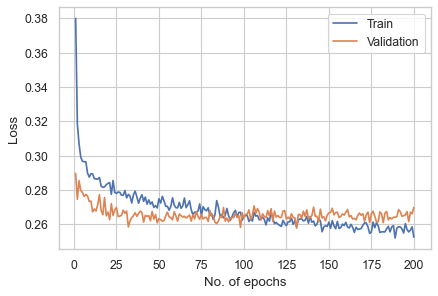

In [13]:
####################################################
#training and val plot plot
####################################################

plt.plot(list(range(1, num_epochs + 1)), all_train_loss, label = 'Train')
plt.plot(list(range(1, num_epochs + 1)), all_val_loss, label = 'Validation')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
writer.flush()